In [73]:
!pip install nba_api

import pandas as pd
import csv
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
from scipy.stats import linregress
from scipy import stats

#Call the data from the player data .csv and truncate to only include 1989-90 seasons onward
closed_file = 'NBA PROJECTS.csv'
players = pd.read_csv(closed_file)
players = players.loc[(players['Tm'] != 'TOT')& (players['Year'] >= 1990)]

In [74]:
record_file = 'NBA Season Records.csv'
name_file = 'NBA Abbreviations.csv'
records = pd.read_csv(record_file)
names = pd.read_csv(name_file)

#Clean the data in the season column to go from str(2016-17) format to float(2017) format
ssns = []
for year in records['Season']:
    yr = int(year.split('-')[1])
    if ((10 <= yr) & (yr < 20)):
        ssns.append(float('20' + str(yr)))
    elif((0 <= yr) & (yr < 10)):
        ssns.append(float('200' + str(yr)))
    else:
        ssns.append(float('19' + str(yr)))
seasons = pd.Series(ssns)
records['Season'] = seasons

#Truncate the data to only represent seasons from 1989-90 onward (removing 2017-18 as it was not in the other dataframe)
records = records.loc[(records['Season'] >= 1990) & (records['Season'] <= 2017)]

#Remove the * after the team name denoting a playoff presence
records['Team'] = records['Team'].str.replace('*', '')

#Change the names of the teams on the record dataset to the abbreviations on the abbreviation dataset
records['Team'] = records['Team'].map(names.set_index('Team')['Abbreviation'])

#Special condition for "Charlotte Hornets." The name was not used contiguously, so additional conditions were needed
records.loc[(records['Team'].isnull() == True) & 
            (records['Season'] >= 2015), 'Team'] = records.loc[(records['Team'].isnull() == True) & 
                                                               (records['Season'] >= 2015), 'Team'].replace({np.nan:'CHA'})
records.loc[(records['Team'].isnull() == True) & 
            (records['Season'] < 2015), 'Team'] = records.loc[(records['Team'].isnull() == True) & 
                                                               (records['Season'] < 2015), 'Team'].replace({np.nan:'NOP'})
records = records.rename(columns = {'Team':'Tm', 'Season':'Year'})

#Denote whether the team made the playoffs that season
records['Made Playoffs'] = records['Playoffs'].notna()

In [75]:
#Rename some of the team abbreviations to capture recent franchise movement/rename.
players = players.replace({'Tm':{'WSB':'WAS', 'VAN': 'MEM', 'NJN': 'BRK', 'SEA': 'OKC', 
                         'CHH':'NOP', 'NOH': 'NOP', 'NOK': 'NOP', 'CHO':'CHA' }})

In [76]:
#Merge the season results data with the player data. Season data is duplicated for each player
nba = pd.merge(players, records, on = ['Year', 'Tm'], how = 'left')

#Write to csv for easier visualization
nba.to_csv("test_output/merge_results.csv", index=False, header=True)

In [77]:
nba

,Unnamed: 0,Year,Player,Pos,Age,Tm,G,GS,MP,PER,...,Pace,Rel_Pace,ORtg,Rel_ORtg,DRtg,Rel_DRtg,Playoffs,Coaches,Top WS,Made Playoffs
0,9547,1990.0,Mark Acres,C,27.0,ORL,80.0,50.0,1691.0,8.3,...,104.1,5.8,105.8,-2.3,114.3,6.2,NaN,M. Guokas (18-64),O. Smith (3.3),False
1,9548,1990.0,Michael Adams,PG,27.0,DEN,79.0,74.0,2690.0,15.4,...,105.4,7.1,108.0,-0.1,106.7,-1.4,Lost W. Conf. 1st Rnd.,D. Moe (43-39),F. Lever (8.8),True
2,9549,1990.0,Mark Aguirre,SF,30.0,DET,78.0,40.0,2005.0,15.8,...,94.4,-3.9,109.9,1.8,103.5,-4.6,Won Finals,C. Daly (59-23),B. Laimbeer (10.1),True
3,9550,1990.0,Danny Ainge,PG,30.0,SAC,75.0,68.0,2727.0,16.1,...,96.7,-1.6,104.8,-3.3,110.0,1.9,NaN,J. Reynolds (7-21) D. Motta (16-38),R. McCray (7.9),False
4,9551,1990.0,Mark Alarie,PF,26.0,WAS,82.0,10.0,1893.0,14.1,...,99.4,1.1,107.5,-0.6,109.7,1.6,NaN,W. Unseld (31-51),D. Walker (6.3),False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13772,24686,2017.0,Cody Zeller,PF,24.0,CHA,62.0,58.0,1725.0,16.7,...,95.7,-0.7,108.8,0.0,108.6,-0.2,NaN,S. Clifford (36-46),K. Walker (8.1),False
13773,24687,2017.0,Tyler Zeller,C,27.0,BOS,51.0,5.0,525.0,13.0,...,96.8,0.4,111.2,2.4,108.4,-0.4,Lost E. Conf. Finals,B. Stevens (53-29),I. Thomas (12.5),True
13774,24688,2017.0,Stephen Zimmerman,C,20.0,ORL,19.0,0.0,108.0,7.3,...,96.8,0.4,103.7,-5.1,110.5,1.7,NaN,F. Vogel (29-53),E. Payton (4.4),False
13775,24689,2017.0,Paul Zipser,SF,22.0,CHI,44.0,18.0,843.0,6.9,...,95.3,-1.1,107.4,-1.4,107.0,-1.8,Lost E. Conf. 1st Rnd.,F. Hoiberg (41-41),J. Butler (13.8),True


In [78]:
nba.columns

Index(['Unnamed: 0', 'Year', 'Player', 'Pos', 'Age', 'Tm', 'G', 'GS', 'MP',
       'PER', 'TS%', '3PAr', 'FTr', 'ORB%', 'DRB%', 'TRB%', 'AST%', 'STL%',
       'BLK%', 'TOV%', 'USG%', 'blanl', 'OWS', 'DWS', 'WS', 'WS/48', 'blank2',
       'OBPM', 'DBPM', 'BPM', 'VORP', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%',
       '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB',
       'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'Lg', 'W', 'L', 'W/L%',
       'Finish', 'SRS', 'Pace', 'Rel_Pace', 'ORtg', 'Rel_ORtg', 'DRtg',
       'Rel_DRtg', 'Playoffs', 'Coaches', 'Top WS', 'Made Playoffs'],
      dtype='object')

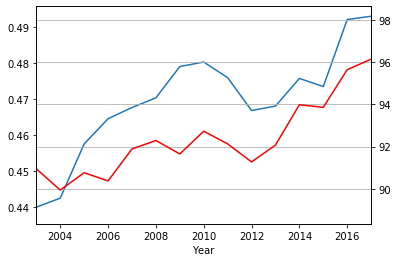

In [164]:
years = nba.groupby(['Year']).mean()
shooting = years[['3P%']].rename(columns = {'3P%': '3P% Yr Avg'})

#shooting.plot(kind = 'line')

efg_years = years['eFG%']
pace_years = years['Pace']
fig, ax = plt.subplots()
ax1 = efg_years.plot()
ax2 = ax1.twinx()
ax2.spines['right'].set_position(('axes', 1.0))
pace_years.plot(ax=ax2, color = 'red', xlim = 2003)
plt.grid(b = True)

In [161]:
teams = nba.groupby(['Tm']).mean()

teamshooting = teams[['TS%', '3PA', '3P%', 'eFG%', 'WS/48', 'Pace']]

teamshooting = teamshooting.sort_values(['eFG%'], ascending = False)
teamshooting

,TS%,3PA,3P%,eFG%,WS/48,Pace
Tm,,,,,,
PHO,0.515472,82.343158,0.287491,0.478081,0.072324,NaN
OKC,0.515467,81.663755,0.268080,0.478076,0.081548,93.208515
SAS,0.514768,72.059322,0.266654,0.477385,0.099737,91.916737
HOU,0.514046,94.860370,0.266066,0.477217,0.078663,93.082136
MIA,0.512808,77.316348,0.285636,0.477098,0.082790,91.125478
BOS,0.513839,76.663180,0.260597,0.473310,0.075052,93.664017
UTA,0.514893,63.487239,0.274371,0.472778,0.078378,91.289095
IND,0.513224,83.721839,0.265474,0.471228,0.083552,92.570805
DET,0.507041,77.656109,0.267817,0.469490,0.082980,90.390950


In [147]:
nba.columns

Index(['Unnamed: 0', 'Year', 'Player', 'Pos', 'Age', 'Tm', 'G', 'GS', 'MP',
       'PER', 'TS%', '3PAr', 'FTr', 'ORB%', 'DRB%', 'TRB%', 'AST%', 'STL%',
       'BLK%', 'TOV%', 'USG%', 'blanl', 'OWS', 'DWS', 'WS', 'WS/48', 'blank2',
       'OBPM', 'DBPM', 'BPM', 'VORP', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%',
       '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB',
       'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'Lg', 'W', 'L', 'W/L%',
       'Finish', 'SRS', 'Pace', 'Rel_Pace', 'ORtg', 'Rel_ORtg', 'DRtg',
       'Rel_DRtg', 'Playoffs', 'Coaches', 'Top WS', 'Made Playoffs'],
      dtype='object')

(0.8241914625349471, 2.1747037866385124e-08)


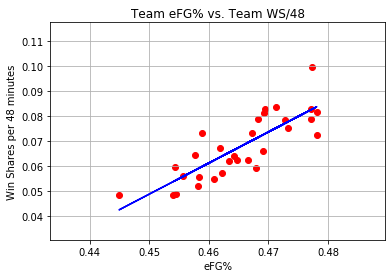

In [163]:
x = teams['eFG%']
y = teams['WS/48']
(slope, intercept, pvalue, rvalue, stderr) = stats.linregress(x,y)
line = slope * x + intercept
cor = st.pearsonr(x, y)
plt.scatter(x,y, facecolors = 'red')
plt.plot(x, line, color = "blue")
plt.grid(b = True)
plt.title('Team eFG% vs. Team WS/48')
plt.xlabel('eFG%')
plt.ylabel('Win Shares per 48 minutes')

print(cor)


In [83]:
shooting

,3P% Yr Avg
Year,
1990.0,0.217191
1991.0,0.211539
1992.0,0.215209
1993.0,0.220591
1994.0,0.235655
1995.0,0.269659
1996.0,0.281043
1997.0,0.285920
1998.0,0.249085


In [12]:
#create column in nba that adds that years avg shooting value to each row
nba_new = pd.merge(nba, shooting, on = ['Year'], how = 'left')
#write .loc where 

nba_above_avg = nba_new.loc[nba_new['3P%'] >= nba_new['3P% Yr Avg']]
nba_above_avg.loc[(nba_above_avg['Year'] == 1995) | (nba_above_avg['Year'] == 2000) | (nba_above_avg['Year'] == 2005) |
                 (nba_above_avg['Year'] == 2010) | (nba_above_avg['Year'] == 2017)]

#combined = {'Present Day' : warriors, '2010' : heat, '2005' : spurs, '2000' : lakers, '1995' : bulls}
#combined_df = pd.DataFrame(combined)
#tcombined = combined_df.transpose()
#tcombined = tcombined[::-1]
#year = combined_df.keys()
#position = 
#nba_above_avg[['Year', 'Player','3P%', '3P% Yr Avg']]
above_avg = nba_above_avg.groupby(['Year', 'Pos']).count()
graph_above_avg = above_avg['Tm']

graph_above_avg_df = pd.DataFrame(graph_above_avg)
graph_above_avg_df
#above_avg
#vg_plot = above_avg['Player']


#graph_above_avg = graph_above_avg.pivot(index = 'Year', columns = 'Pos', values = 'Player')

Tm
Year   Pos    
1990.0 C    14
       PF   23
       PG   49
       SF   41
       SG   50
...         ..
2017.0 C    28
       PF   61
       PG   77
       SF   74
       SG   88

[140 rows x 1 columns]

In [13]:
warriors2016 = nba.loc[(nba["Tm"] == 'GSW') & (nba["Year"] == 2016 )]
bulls1996 = nba.loc[(nba["Tm"] == 'CHI') & (nba["Year"] == 1996 )]

nba.columns

Index(['Unnamed: 0', 'Year', 'Player', 'Pos', 'Age', 'Tm', 'G', 'GS', 'MP',
       'PER', 'TS%', '3PAr', 'FTr', 'ORB%', 'DRB%', 'TRB%', 'AST%', 'STL%',
       'BLK%', 'TOV%', 'USG%', 'blanl', 'OWS', 'DWS', 'WS', 'WS/48', 'blank2',
       'OBPM', 'DBPM', 'BPM', 'VORP', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%',
       '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB',
       'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'Lg', 'W', 'L', 'W/L%',
       'Finish', 'SRS', 'Pace', 'Rel_Pace', 'ORtg', 'Rel_ORtg', 'DRtg',
       'Rel_DRtg', 'Playoffs', 'Coaches', 'Top WS', 'Made Playoffs'],
      dtype='object')

In [14]:
warriors2016['3P%'].mean()

newwarriors2016 = warriors2016[['Player', 'Pos', 'G', 'FGA', '2PA', '3PA', '3P%', 'WS/48' ]]
newwarriors2016

,Player,Pos,G,FGA,2PA,3PA,3P%,WS/48
12739,Leandro Barbosa,SG,68.0,370.0,260.0,110.0,0.355,0.092
12742,Harrison Barnes,SF,66.0,633.0,419.0,214.0,0.383,0.116
12762,Andrew Bogut,C,70.0,279.0,278.0,1.0,1.000,0.180
12797,Ian Clark,SG,66.0,202.0,118.0,84.0,0.357,0.075
12817,Stephen Curry,PG,79.0,1598.0,712.0,886.0,0.454,0.318
12849,Festus Ezeli,C,46.0,228.0,228.0,0.0,NaN,0.171
12884,Draymond Green,PF,81.0,819.0,561.0,258.0,0.388,0.190
12942,Andre Iguodala,SF,65.0,368.0,214.0,154.0,0.351,0.122
13005,Shaun Livingston,PG,78.0,379.0,367.0,12.0,0.167,0.145
13006,Kevon Looney,PF,5.0,7.0,5.0,2.0,0.500,0.192


In [15]:
newbulls2016 = bulls1996[['Player', 'Pos', 'G', 'FGA', '2PA', '3PA', '3P%', 'WS/48' ]]
newbulls2016

,Player,Pos,G,FGA,2PA,3PA,3P%,WS/48
2608,Randy Brown,PG,68.0,192.0,181.0,11.0,0.091,0.105
2610,Jud Buechler,SF,74.0,242.0,152.0,90.0,0.444,0.148
2615,Jason Caffey,PF,57.0,162.0,161.0,1.0,0.000,0.038
2676,James Edwards,C,28.0,110.0,110.0,0.0,NaN,-0.028
2724,Jack Haley,C,1.0,6.0,6.0,0.0,NaN,-0.228
2734,Ron Harper,PG,80.0,501.0,397.0,104.0,0.269,0.161
2769,Michael Jordan*,SG,82.0,1850.0,1590.0,260.0,0.427,0.317
2774,Steve Kerr,PG,82.0,482.0,245.0,237.0,0.515,0.208
2784,Toni Kukoc,SF,81.0,787.0,571.0,216.0,0.403,0.231
2800,Luc Longley,C,62.0,502.0,502.0,0.0,NaN,0.101


In [135]:
warriors3pt = warriors2016['3P'].sum() / warriors2016['3PA'].sum()
warriors3pa = warriors2016['3PA'].sum()
warriors3dist = warriors2016['3PA'].sum() / warriors2016['FGA'].sum()
warriorspps = warriors2016['PTS'].sum() / (warriors2016['FGA'].sum() + warriors2016['FTA'].sum())
warriorspace = warriors2016['Pace'].mean()



warriordict = {'Three Point Percentage' : warriors3pt, 'Three Point Attempts' : warriors3pa, 
              "3% of overall FGA" : warriors3dist, "Points per Shot" : warriorspps}


warriordict
##############

bulls3pt = bulls1996['3P'].sum() / bulls1996['3PA'].sum()
bulls3pa = bulls1996['3PA'].sum()
bulls3dist = bulls1996['3PA'].sum() / bulls1996['FGA'].sum()
bullspps = bulls1996['PTS'].sum() / (bulls1996['FGA'].sum() + bulls1996['FTA'].sum())
bullspace = bulls1996['Pace'].mean()

###


bullsdict = {'Three Point Percentage' : bulls3pt, 'Three Point Attempts' : bulls3pa, 
              "3% of overall FGA" : bulls3dist, "Points per Shot" : bullspps}


#bulls3pa
#warriors3pa = warriors2016['3PA'].sum()
#warriors3dist
#warriorspps

#bullspps
#warriors2016['3PA'].sum() / 82

In [119]:
warriordict

{'Three Point Percentage': 0.41550925925925924,
 'Three Point Attempts': 2592.0,
 '3% of overall FGA': 0.3620617404665456,
 'Points per Shot': 1.0527433232763437}

In [18]:
avgteam = nba.loc[nba["Year"] == 2016 ]
teampace = avgteam['Pace']
teams = avgteam.groupby(['Tm']).sum()
twopointatt = teams['2PA'] /82
threepointatt = teams['3PA'] /82
twopoint = teams['2P'] /82
threepoint = teams['3P'] /82
twoper = twopoint / twopointatt
threeper = threepoint / threepointatt

In [19]:
#nets = nba.loc[(nba["Tm"] == 'BRK') & (nba["Year"] == 2016)]


In [61]:
##############

bulls_3per = bulls1996['3P'].sum() / bulls1996['3PA'].sum()
bulls_2per = bulls1996['2P'].sum() / bulls1996['2PA'].sum()
bulls_3pa = bulls1996['3PA'].sum()
bulls_2pa = bulls1996['2PA'].sum()
bulls_3 = bulls1996['3P'].sum()
bulls_2 = bulls1996['2P'].sum()
bullsft = bulls1996['FT'].sum()


bulls3dist = bulls1996['3PA'].sum() / bulls1996['FGA'].sum()
bullspps = bulls1996['PTS'].sum() / (bulls1996['FGA'].sum() + bulls1996['FTA'].sum())
bullspace = bulls1996['Pace'].mean()


###


In [67]:
bulls_2ppg = bulls_2 /82
bulls_2tot = bulls_2ppg * 2
bulls_2tot

67.04878048780488

In [69]:
bulls_3

544.0

In [62]:
bullsft / 82

18.23170731707317